In [13]:
import tkinter as tk
import numpy as np
import math
import matplotlib.pyplot as plt

In [44]:
import utils as ut
from importlib import reload
ut = reload(ut)
UtilsRender = ut.UtilsRender

In [26]:
# Define the payload
payload = {
    "capRadius": 20,
    "configs": [
        {"capIndex": 0, "capCenter": {"x": 250, "y": 250}},
        {"capIndex": 1, "capCenter": {"x": 200, "y": 250}},
        {"capIndex": 2, "capCenter": {"x": 550, "y": 550}},
    ],
    "arrow": {"capIndex": 0, "distance": 100, "angle": 20},
}

In [27]:
response = {
  "motion": [
    {
      "t": 0,
      "configs": [
        { "capIndex": 0, "capCenter": { "x": 250, "y": 250 }},
        { "capIndex": 1, "capCenter": { "x": 200, "y": 250 }},
        { "capIndex": 2, "capCenter": { "x": 550, "y": 555 }}
      ]
    },
    {
      "t": 1,
      "configs": [
        { "capIndex": 0, "capCenter": { "x": 255, "y": 250 }},
        { "capIndex": 1, "capCenter": { "x": 205, "y": 250 }},
        { "capIndex": 2, "capCenter": { "x": 550, "y": 555 }}
      ]
    },
    {
      "t": 2,
      "configs": [
        { "capIndex": 0, "capCenter": { "x": 260, "y": 250 }},
        { "capIndex": 1, "capCenter": { "x": 210, "y": 250 }},
        { "capIndex": 2, "capCenter": { "x": 550, "y": 559 }}
      ]
    },
    {
      "t": 3,
      "configs": [
        { "capIndex": 0, "capCenter": { "x": 370, "y": 250 }},
        { "capIndex": 1, "capCenter": { "x": 220, "y": 250 }},
        { "capIndex": 2, "capCenter": { "x": 550, "y": 570 }}
      ]
    }
  ]
}

In [28]:
UtilsRender.render_motion_json(payload, response)

# Simplify problem

In [64]:
w = 1920
h = 1080
delay = 100

# Define the payload
payload = {
    "capRadius": 20,
    "configs": [
        {"capIndex": 0, "capCenter": {"x": w//3, "y": h//2}},
        {"capIndex": 1, "capCenter": {"x": int(w*2//3), "y": h//2}},
    ],
    "arrow": {"capIndex": 0, "distance": 100, "angle": 0},
}

# Get the coordinates from payload to create an array 2D of positions
pos = np.array([[config["capCenter"]["x"], config["capCenter"]["y"]] for config in payload["configs"]])
idx = np.array([config["capIndex"] for config in payload["configs"]])

# Radius
cap_radius = payload["capRadius"]

# Arrow properties detection
arrow = payload["arrow"]
arrow_idx = arrow["capIndex"]
arrow_velocity = arrow["distance"]
arrow_angle = arrow["angle"]
arrow_angle_rad = np.radians(arrow_angle)

ur = UtilsRender(cap_radius=cap_radius, window_size=(w, h), delay=delay)

In [65]:
%%time
# Create the physics to start moving the cap "move_idx" in the direction of the arrow arrow_angle_rad
# The movement will be done step by step

# Which is the index of the pos matrix (row) for the cap to move
move_idx = np.where(arrow_idx == idx)[0][0]

# Initialize parameters
initial_velocity = 30
friction_coefficient = 0.1
min_velocity = 2 

# Initialize velocity
velocity = initial_velocity

# Initialize list to store positions
positions = [pos.copy()]
velocities = [velocity]

# Calculate direction vector from angle
direction = np.array([math.cos(arrow_angle_rad), -math.sin(arrow_angle_rad)])

# Start movement loop
t = -1
while velocity >= min_velocity:
    if t >= 30:
        print("Debug here")
        break
    t += 1
    # Calculate new position
    move = direction * velocity
    new_pos = pos[move_idx] + move

    # Check for collision with field edges
    if new_pos[0] - cap_radius < 0 or new_pos[0] + cap_radius > w or new_pos[1] - cap_radius < 0 or new_pos[1] + cap_radius > h:
        print("Collision with field edges")
        break

    # Check for collision with other caps
    for i, cap_pos in enumerate(pos):
        if i != move_idx:
            distance = np.linalg.norm(new_pos - cap_pos)
            if distance < 2 * cap_radius:
                if distance < velocity:
                    velocity = distance
                    move = direction * velocity
                    new_pos = pos[move_idx] + move
                print("Collision with other cap")
                break
    else:
        # Update position and velocity
        pos[move_idx] = new_pos
        velocity -= friction_coefficient * (velocity/10)**3

        # Store new position
        positions.append(pos.copy())

        # Store velocity to velocities
        velocities.append(velocity)

        continue

    break

# Convert positions to numpy array
positions = np.array(positions)

Debug here
CPU times: user 927 µs, sys: 434 µs, total: 1.36 ms
Wall time: 1.04 ms


In [72]:
new_pos

array([1144.61969792,  540.        ])

In [73]:
cap_pos

array([1280,  540])

In [74]:
distance

135.38030207614793

In [68]:
distance = np.linalg.norm(new_pos - cap_pos)
distance

135.38030207614793

In [59]:
move_idx = 0
for i, cap_pos in enumerate(pos):
    if i != move_idx:
        distance = np.linalg.norm(new_pos - cap_pos)
        if distance < 2 * cap_radius:
            if distance < velocity:
                velocity = distance
                move = direction * velocity
                new_pos = pos[move_idx] + move
            print("Collision with other cap")


Collision with other cap


In [69]:
ur.render_snapshot(pos)

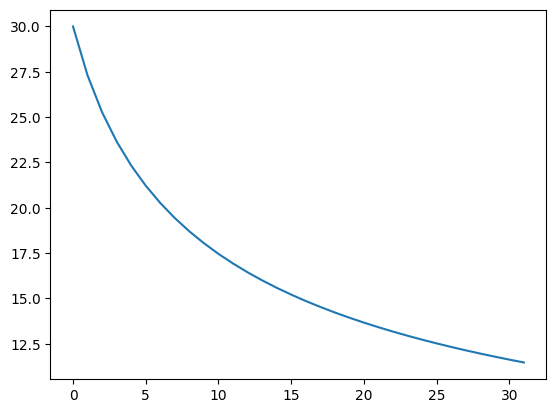

In [48]:
plt.plot(velocities)

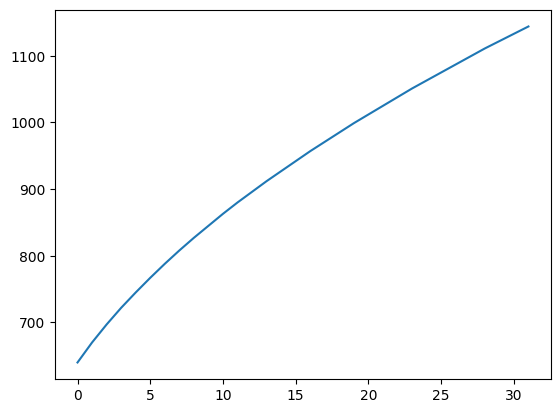

In [49]:
# Plot x component of the first cap
plt.plot(positions[:, 0, 0])

In [50]:
ur.render_motion(positions)

In [182]:
def render_motion(positions, cap_radius, window_size=(1920, 1080), delay=100):
    # Create the tkinter window
    root = tk.Tk()
    root.geometry(f"{window_size[0]}x{window_size[1]}")

    # Create a canvas for drawing
    canvas = tk.Canvas(root, width=window_size[0], height=window_size[1])
    canvas.pack()

    # Create a label for displaying the timestep
    timestep_label = tk.Label(root, text="Timestep: 0")
    timestep_label.place(x=10, y=10)

    # Draw the initial circles
    circles = []
    for pos in positions[0]:
        x, y = pos
        circle = canvas.create_oval(x-cap_radius, y-cap_radius, x+cap_radius, y+cap_radius)
        circles.append(circle)

    # Define a function to update the position of the circles
    def update_position(timestep):
        timestep = int(timestep)
        if timestep < len(positions):
            for i, pos in enumerate(positions[timestep]):
                x, y = pos
                circle = circles[i]
                canvas.coords(circle, x-cap_radius, y-cap_radius, x+cap_radius, y+cap_radius)
            # Update the timestep label
            timestep_label.config(text=f"Timestep: {timestep}")
            root.after(delay, update_position, str(timestep+1))

    # Start the animation
    root.after(delay, update_position, "0")

    # Start the tkinter event loop
    root.mainloop()

# Test the function
cap_radius = 50
render_motion(positions, cap_radius)

: 